# A path-dependent McKean-Vlasov model for neural masses.

This notebook implements the simulations described in Section 2.2 of

- Bernou, A. and Liu, Y. (2024). Particle method for numerical simulation of the path-dependent McKean-Vlasov equation.

-------------------------------

**Contents**

* [1. Definition of the model](#chapter1)

* [2. Definition of the particle system and of the Euler scheme](#chapter2)

* [3. Simulation with M = 100](#chapter3)

* [4. Estimation of the Wasserstein distance by coordinates](#chapter4)

* [5. Estimation via a test function](#chapter5)

-------------------------------

Throughout this notebook, we refer several times to [FTC09], which designates the article of
O. Faugeras, J. Touboul, and B. Cessac, *A constructive mean-field analysis of multi population neural networks with random synaptic weights and stochastic inputs*. Frontiers in Computational Neuroscience, 3, 2009.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from joblib import Parallel, delayed
import time
import shutil

import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Definition of the model <a class="anchor" id="chapter1"></a>


We consider a stochastic process $(\bar V_t)_{t\in[0, T]}$ with $\bar V_t \in \mathbb{R}^3$ for each $t \ge 0$ defined by the following McKean-Vlasov SDE
\begin{align*}
\left\{
	\begin{array}{ll}
d \bar V_j(t) &= \Big\{-\frac{V_j(t)}{\tau_j} + \sum_{k=1}^3 D_{j,k} \Big( 1 + \varepsilon \int_0^t \varphi\big(\bar V_j(u)\big) d u \Big) \int_{\mathbb{R}} S(y) \mu^k_{t-\triangle}(d y)+ I_j(t) \Big\} d t +  f_j(t) d W^j_t \\
		\bar V_j(t) &\sim \mu^j_t, \quad t \in [0,T],
		\end{array}
		\right.
  \end{align*}

where for every  $t\in[0,T]$, $\mu^k_t$ denotes the probability distribution of $\bar V_k(t)$.  This process models the limit behavior of the underlying potential of three different neural populations in the mean-field limit. This is an extension of the model considered in [FTC09] which accounts for excitability and delay through the use of the whole trajectories.








We consider the following parameters:
- $\varphi(x) = e^{-|x|}$ on $\mathbb{R}$,
- $f_j \equiv 1$ for all $j$,
- $I_j \equiv 0$,
- $\Delta = 0.1$,
- $T = 1$,
- $\varepsilon = 0.1$,
- $D_{1,2} = 1$, $D_{1,3} = 1$, $D_{2,1} = 5$, $D_{3,1} = -3$, $D_{i,i} = 1$ for all $i \in \{1,2,3\}$ and $D_{i,j}$ for all other $(i,j) \in \{1,2,3\}^2$.
- $S(v) = \frac{10}{1 + e^{(1-v)}}$,
- $\tau = (\tau_j)_{1\le j\le 3}$ with $\tau = (1,1,1)$.

With those parameters, the model rewrites:
\begin{align*}
\left\{
	\begin{array}{ll}
d \bar V_j(t) &= \Big\{-\bar V_j(t) + \sum_{k=1}^3 D_{j,k} \Big( 1 + 0.1 \int_0^t e^{-|\bar V_j(u)|}\Big) d u \Big) \int_{\mathbb{R}} \frac{10}{1+e^{1-y}} \mu^k_{t-\triangle}(d y) \Big\} dt\\
		&\qquad \qquad +  d W^j_t \\
		\\
		&\bar V_j(t) \sim \mu^j_t, \quad t \in [0,T],
		\end{array}
		\right.
  \end{align*}

# 2. Definition of the particle system and of the Euler scheme  <a class="anchor" id="chapter2"></a>

Let $N$ be the number of particles. The $N$-particle system $(V_t^{1}, ..., V_t^{N})_{t\in[0,T]}$ corresponding to Equation (1) is defined as follows :

\begin{equation}
\begin{aligned}
V_{j,i}(t) &= V_{j,i}(0) - \int_0^t V_{j,i}(s) ds + \int_0^t \sum_{k=1}^3 \sum_{\ell = 1}^N \frac{D_{j,k}}{N}  \Big( 1 + 0.1 \int_0^s e^{-|V_{j,i}(u)|} d u \Big)  \frac{10}{1 + e^{1 - V_{k,\ell}(s - \Delta)}} ds + W^{j,i}(t).
\end{aligned}
\end{equation}

Since a delay is included in the equation, we will take as initial data, for all $t \in [0, 0.2]$, $\bar V_j(t) = (1,0,-1)$, and accordingly
$V_{\cdot,i}(t) = (1,0,-1)$ for all $t \in [0,0.2]$, all $1 \le i \le N$.

Let $M$ denote the time discretization number for the Euler scheme. Set $h=\frac{T}{M}$ and $t_m=m\cdot h, 0\leq m\leq M$. Combining the particle system (2) and the Euler scheme, we obtain the following discrete particle system :
\begin{equation} V^{n}_{t_{m}} = (1,0,-1) \hbox{ for } t_m \le 0.1; \end{equation}
\begin{equation}
V^{n}_{t_{m+1}}=(1-h) V^{n}_{t_{m}} + \frac{h}{N} \Big( 1+ 0.1 \sum_{q = 0}^p e^{-|V^{n}_{t_m}(q)|}\Big) \sum_{\ell=1}^N  D H^{\ell}_{t_m, \Delta} + \sqrt{h} Z_{p+1}
,\quad 1\leq n\leq N,
\end{equation}
where $ \: Z_{m+1}^{n}:=\frac{1}{\sqrt{h}}(B^n_{t_{m+1}}-B^n_{t_{m}})$ are i.i.d random variables having the standard normal distribution $\mathcal{N}(0,I_3)$, and where for all $p \in \{0,\dots,M\}$, $H_{t_p,\Delta} \in \mathbb{R}^3$ with $k \in \{1,2,3\}$,
\begin{equation}
(H^{\ell}_{t_p,\Delta})_k =  \frac{10}{1 + e^{1 - V^{\ell,k}(t_p - \Delta)}}
\end{equation}

We start with the function initializing the data.

In [3]:
def init_step(V_0, step_0, h):
  data = np.transpose(np.repeat(V_0, step_0+1, axis = 0))
  return data

In [4]:
def H(V_in, step_in, Delta,h):
  #pre_factor = 1 + 0.1*np.sum(np.exp(-np.abs(V_in[:,:,0:step_in])), axis = 2)
  #print(pre_factor)
  return (10 / (1 + np.exp(1-V_in[:,:,step_in-int(Delta/h)])))

In the next cell, the function `Euler_one_step` defines the operator of the Euler scheme for one time step. Note that the current array will be 3-dimensional, with M matrices of size (particle_number, 3)

In [5]:
def Euler_one_step(step_0, step_in,V_in,N_in, Z_in,h, D):
    nn=np.ones(N_in)/N_in
    t_in = step_in*h
    H_inc = np.reshape(np.array(H(V_in, step_in, Delta,h) ), (N_in, 3, 1))
    H_vec = [np.transpose(H_inc[:,:,j]) for j in range(H_inc.shape[2])]
    drift_first_factor = 1 + 0.1*np.sum(np.exp(-np.abs(V_in[:,:,0:step_in])), axis = 2)
    drift_inc = drift_first_factor*np.array([np.matmul(D, H_inc[j,:,0]) for j in range(N_in)])
    V_temp = V_in[:,:,step_in]*(1-h) + h/(N_in)*drift_inc + np.sqrt(h)*Z_in[:,:,step_in+1]
    return V_temp

First, we compute and save the particle systems at time T=1 with different particle numbers in `N_vec`. For each given particle number, we implement 30 identical and independent simulations.

In [ ]:
def one_sim(N_in, nns, M, V_0, Delta, D):
  h = T/M
  time_step = np.linspace(0,T,M, endpoint =True)
  step_0 = np.argmax(time_step>Delta)-1
  V_in = np.array([init_step(V_0, step_0,h)]*N_in)
  V_in = np.concatenate((V_in, np.zeros((N_in,3,M-step_0))), axis = 2)
  Z_in = np.random.normal(size=(N_in, 3,M+1))

  for i in range(step_0, time_step.shape[0]):
    V_in[:,:,i+1] = Euler_one_step(step_0,i,V_in,N_in,Z_in,h, D)
  path = "Neural_mass_particle_num_"+str(N_in)+"repeat_"+str(nns)+"M_"+str(M)+".csv"
  # destination_path = '/content/drive/MyDrive/Results_NM/'+path ## Change destination path on this line if necessary
  np.savetxt(destination_path, V_in[:,:,-1], delimiter=",")


# 3) Simulation with M = 100 <a class="anchor" id="chapter3"></a>

We consider $N\in\{2^7=128, 2^8=256, ..., 2^{16}=65536\}$.

In [6]:
# Parameters

T=1.
NNs = 30
M = 100
h = T/M
V_0 = np.array([[1,0,-1]])
Delta = 0.1
D = np.array([[1,1,1],[5,1,0],[-3,0,1]])
pn = 10
base = 7
N_power=np.linspace(base,base+pn-1,pn)
N_vec=2**N_power.astype(int)
print(N_vec)


[  128   256   512  1024  2048  4096  8192 16384 32768 65536]


The following cell computes the result of our Euler scheme. As the data are already present in the repository, it may be skipped if one focuses on the estimations methods. If not, the destination_path commented in the one_sim function above must be modified.

In [ ]:
start = time.time()
for i in range(pn):
      Delta = .1
      step_0 = int(Delta/h)
      print("Step"+str(i)+", M = "+str(M)+", N = "+str(N_vec[i]))
      Parallel(n_jobs = 4)(delayed(one_sim)(N_vec[i], j, M, V_0, Delta, D) for j in tqdm(range(NNs)))
end = time.time()
print(end-start)

Step0, M = 100, N = 128


100%|██████████| 30/30 [00:02<00:00, 10.35it/s]


Step1, M = 100, N = 256


100%|██████████| 30/30 [00:03<00:00,  9.61it/s]


Step2, M = 100, N = 512


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


Step3, M = 100, N = 1024


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Step4, M = 100, N = 2048


100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


Step5, M = 100, N = 4096


100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


Step6, M = 100, N = 8192


100%|██████████| 30/30 [01:43<00:00,  3.46s/it]


Step7, M = 100, N = 16384


100%|██████████| 30/30 [03:32<00:00,  7.08s/it]


Step8, M = 100, N = 32768


100%|██████████| 30/30 [07:11<00:00, 14.37s/it]


Step9, M = 100, N = 65536


100%|██████████| 30/30 [14:30<00:00, 29.01s/it]


2168.3104915618896


# 4) Estimation of the Wasserstein distance by coordinates. <a class="anchor" id="chapter4"></a>

In the next cells, we compute an empirical Wasserstein distance.
We start by computing the vector of theoretical quantiles for the target distribution.

In [7]:
def estim_Wp(a,b, epsilon,p): ## takes two vectors of values and compute the estimated integral.
    n = len(a)
    res = ((1-2*epsilon)/n)*(((a[0] - b[0])**p + (a[-1]+b[-1])**p)/2 + np.sum((a[1:-1] - b[1:-1])**p))
    return(res)

In [8]:
### Extract theoretical value from final quantile for each dimension
epsilon = 10**(-6) ## can't compute int_0^1 with quantiles as this gives infinite values
# epsilon is here the truncation value
p = 2
NNs = 30
precision_integral = 10**6
quantile_vector = np.arange(0.01,1,1/precision_integral)
quantile_theoretical = []
for i in tqdm(range(3)):
  quantile_theoretical.append(np.zeros((NNs, quantile_vector.shape[0])))
  for nns in tqdm(range(NNs)):  ## Monte-Carlo repetition
        Delta = .1
        step_0 = int(Delta/h)
        ## Change the second line below to access data stored somewhere.
        path = "Neural_mass_particle_num_"+str(N_vec[-1])+"repeat_"+str(nns)+"M_"+str(M)+".csv"
        density_limit = np.array(pd.read_csv("/content/drive/MyDrive/Results_NM/"+path, sep=',',header=None))[:,i]
        quantile_theoretical[i][nns,:]= np.quantile(density_limit, quantile_vector)
        ## We have NNs simulations with 2^7 particles for instance. Here we upload the last iteration (result at time T).
        ## Let us estimate the Wasserstein distance with respect to the true distribution.

100%|██████████| 3/3 [04:26<00:00, 88.89s/it]


In [9]:
epsilon = 10**(-6) ## can't compute int_0^1 with quantiles as this gives infinite values
# epsilon is the truncation value
p = 2
NNs = 30
precision_integral = 10**6
quantile_vector = np.arange(0.01,1,1/precision_integral)
error_basic = np.zeros((pn, 3, NNs, M))
max_error = np.zeros((pn, NNs))
error_final = np.zeros((pn,3))
for i in tqdm(range(pn)):   ## particle number
  for j in range(3):
    for nns in range(NNs):  ## Monte-Carlo repetition
        #print("N = "+str(N_vec[i])+", M = "+str(M))
        ## Change the second line below to access data stored somewhere else.
        path = "Neural_mass_particle_num_"+str(N_vec[i])+"repeat_"+str(nns)+"M_"+str(M)+".csv"
        density_particle= np.array(pd.read_csv("/content/drive/MyDrive/Results_NM/"+path, sep=',',header=None))[:,j]
        ## We have NNs simulations with 2^7 particles for instance. Here we upload the last iteration (result at time T).
        ## Let us estimate the Wasserstein distance with respect to the true distribution.
        quantile_method = np.quantile(density_particle, quantile_vector)
        error_basic[i, j, nns] = estim_Wp(quantile_method, quantile_theoretical[j][nns,:], epsilon, p)
    ### Computing the finate global error
    error_final[i,j] = np.mean(error_basic[i,j,:]**p)

100%|██████████| 10/10 [08:18<00:00, 49.86s/it] 


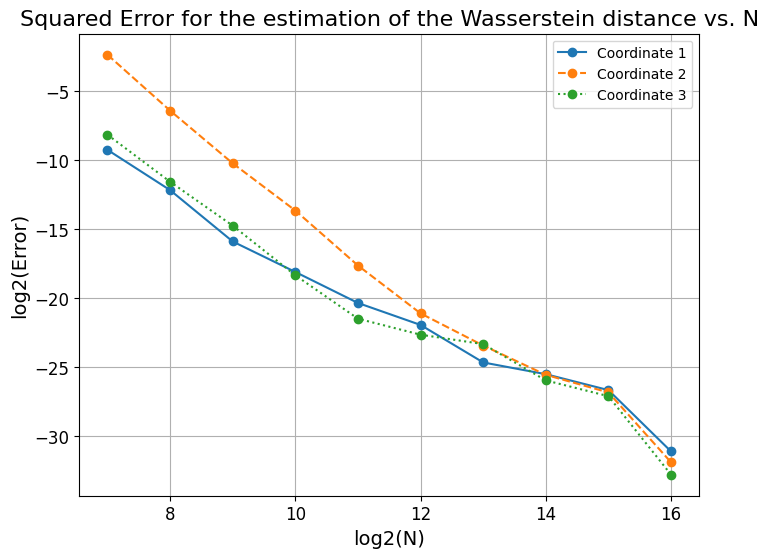

In [10]:
plt.figure(figsize=(8,6))

for j, linestyle in enumerate(['-', '--', ':']):
    plt.plot(np.log2(N_vec), np.log2(error_final[:, j]), linestyle = linestyle, marker="o", label=f'Coordinate {j+1}')

plt.xlabel('log2(N)', fontsize=14) # Adjust fontsize as needed
plt.ylabel('log2(Error)', fontsize=14) # Adjust fontsize as needed
plt.title('Squared Error for the estimation of the Wasserstein distance vs. N', fontsize=16) # Adjust fontsize as needed
plt.legend()
plt.grid(True)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('/content/drive/MyDrive/NMM_Coord.eps', format='eps')

plt.show()

In [11]:
for j in range(3):
  print (j)
  X=np.log2(N_vec[:-1]).reshape(-1,1)
  y=np.log2(error_final[:-1,j])
  reg_Gaussian = LinearRegression().fit(X, y)
  print ("The estimate of the slope is", reg_Gaussian.coef_)
  print ("The estimate of the intercept is", reg_Gaussian.intercept_)

0
The estimate of the slope is [-2.18541249]
The estimate of the intercept is 4.640170998842393
1
The estimate of the slope is [-3.15554861]
The estimate of the intercept is 18.350294491313463
2
The estimate of the slope is [-2.34253018]
The estimate of the intercept is 6.501858178455787


# 5) Estimation by test function <a class="anchor" id="chapter5"></a>



In [12]:
p = 2
NNs = 30
T  = 1
M = 100
h = T/M

def phi_1(x):
  norm = np.linalg.norm(x, axis=1)
  mask = norm < 1
  y = np.zeros(len(norm))
  y[mask] = norm[mask]
  return(np.exp(-(1/(1+y**2))))

def phi_2(x):
  return(np.exp(-(np.linalg.norm(x, axis=1))**2 / 2))

def phi_3(x):
  norm = np.linalg.norm(x, axis=1)
  return(1/(1+np.exp(-norm)))



error_max = np.zeros((3,NNs))



### Compute error at larger particle number

for nns in tqdm(range(NNs)):  ## Monte-Carlo repetition
      ## Change the second line below to access data stored somewhere else.
      path = "Neural_mass_particle_num_"+str(N_vec[-1])+"repeat_"+str(nns)+"M_"+str(M)+".csv"
      density_particle= np.array(pd.read_csv("/content/drive/MyDrive/Results_NM/"+path, sep=',',header=None))
      error_max[0,nns] = np.mean(phi_1(density_particle))
      error_max[1,nns] = np.mean(phi_2(density_particle))
      error_max[2,nns] = np.mean(phi_3(density_particle))



error_basic = np.zeros((3, pn-1, NNs))
error_final = np.zeros((3,pn-1))
for j in tqdm(range(7, 7+pn-1)):   ## particle number
    i = j-7
    for nns in range(NNs):  ## Monte-Carlo repetition
        #print("N = "+str(N_vec[i])+", M = "+str(M))
        ## Change the second line below to access data stored somewhere else.
        path = "Neural_mass_particle_num_"+str(N_vec[i])+"repeat_"+str(nns)+"M_"+str(M)+".csv"
        density_particle= np.array(pd.read_csv("/content/drive/MyDrive/Results_NM/"+path, sep=',',header=None))
        error_basic[0, i, nns] = np.mean(phi_1(density_particle))
        error_basic[1, i, nns] = np.mean(phi_2(density_particle))
        error_basic[2, i, nns] = np.mean(phi_3(density_particle))
    error_final[0,i] = 8*np.mean(np.abs(error_basic[0,i,:] - error_max[0,:]))
    error_final[1,i] = 8*np.mean(np.abs(error_basic[1,i,:] - error_max[1,:]))
    error_final[2,i] = 8*np.mean(np.abs(error_basic[2,i,:] - error_max[2,:]))
        ## We have NNs simulations with 2^7 particles for instance. Here we upload the last iteration (result at time T).
        ## Let us estimate the Wasserstein distance with respect to the true distribution.
        #quantile_method = np.quantile(density_particle, quantile_vector)
        #

    ### Computing the finate global error


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


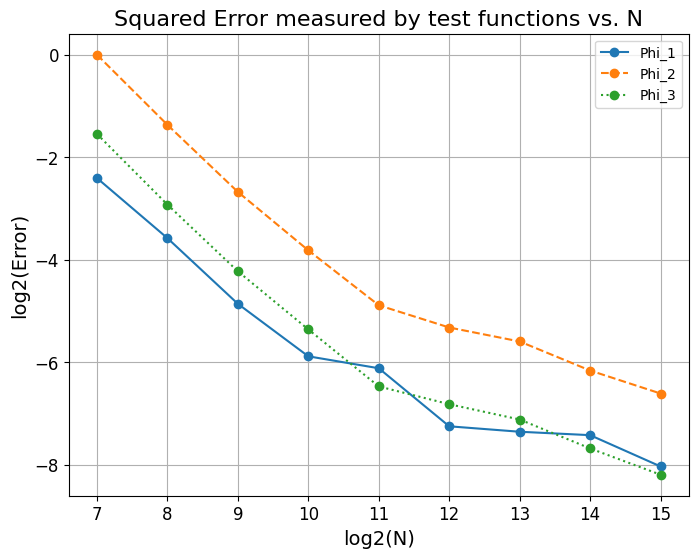

In [13]:
plt.figure(figsize=(8,6))

for j, linestyle in enumerate(['-', '--', ':']):
    plt.plot(np.log2(N_vec[:-1]), np.log2(error_final[j,:]), linestyle = linestyle, marker="o", label=f'Phi_{j+1}')

plt.xlabel('log2(N)', fontsize=14) # Adjust fontsize as needed
plt.ylabel('log2(Error)', fontsize=14) # Adjust fontsize as needed
plt.title('Squared Error measured by test functions vs. N', fontsize=16) # Adjust fontsize as needed
plt.legend()
plt.grid(True)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('/content/drive/MyDrive/NMM_TestW.eps', format='eps')

plt.show()

In [14]:
for j in range(3):
  print (j)
  X=np.log2(N_vec[:-1]).reshape(-1,1)
  y=np.log2(error_final[j,:])
  reg_Gaussian = LinearRegression().fit(X, y)
  print ("The estimate of the slope is", reg_Gaussian.coef_)
  print ("The estimate of the intercept is", reg_Gaussian.intercept_)

0
The estimate of the slope is [-0.67325945]
The estimate of the intercept is 1.5237429886524039
1
The estimate of the slope is [-0.80269774]
The estimate of the intercept is 4.777394269095901
2
The estimate of the slope is [-0.80178525]
The estimate of the intercept is 3.2229735500171293
